In [0]:
pip install azure-storage-blob

Python interpreter will be restarted.
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Not uninstalling typing-extensions at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-47fa1db8-94fb-4c73-a7e9-9c33bfe50ba1
    Can't uninstall 'typing-extensions'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
import requests
import pandas as pd
import json
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
from azure.core.pipeline.transport import HttpResponse
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, ArrayType
import gzip

In [0]:
def get_data(date, time):
    url = "https://data.gharchive.org/"+ str(date) +'-'+ str(time) +'.json.gz'
    print(url)
    response = requests.get(url)

    if response.status_code == 200:
       with open("cache.json.gz", "wb") as file:
            file.write(response.content)
       print("File downloaded successfully.")
    else:
       print("Error downloading the file.")

In [0]:
def unzip_jsongz():
    input_file = '/databricks/driver/cache.json.gz'
    output_file = '/databricks/driver/cache.json'
    with gzip.open(input_file, 'rb') as gz_file:
        with open(output_file, 'wb') as out_file:
            out_file.write(gz_file.read())

In [0]:
def upload_to_blob_storage( connection_string, container_name, file_path, blob_name):
    blob_service_client = BlobServiceClient.from_connection_string(connection_string)
    blob_client = blob_service_client.get_blob_client(container= container_name, blob= blob_name)

    with open(file_path, "rb") as data:
        blob_client.upload_blob(data)

In [0]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [0]:
get_data("2023-04-04", 15)
unzip_jsongz()

https://data.gharchive.org/2023-04-04-15.json.gz
File downloaded successfully.


In [0]:
df = spark.read.json("file:///databricks/driver/cache.json")
df.head()

Out[7]: Row(actor=Row(avatar_url='https://avatars.githubusercontent.com/u/108474434?', display_login='appseed-projects2', gravatar_id='', id=108474434, login='appseed-projects2', url='https://api.github.com/users/appseed-projects2'), created_at='2023-04-04T15:00:04Z', id='28197453071', org=None, payload=Row(action=None, before='cc9abfdb6c1be48d7823c4603c5398dabc613dcc', comment=None, commits=[Row(author=Row(email='108474434+appseed-projects2@users.noreply.github.com', name='AppSeed Generated Projects'), distinct=True, message='initial commit', sha='05ff2e573c591b1a8bbf0f4f1de0455c9fb5386b', url='https://api.github.com/repos/appseed-projects2/7306edf7-7654-4bb2-a8ff-d34925aa9b7c/commits/05ff2e573c591b1a8bbf0f4f1de0455c9fb5386b')], description=None, distinct_size=1, forkee=None, head='05ff2e573c591b1a8bbf0f4f1de0455c9fb5386b', issue=None, master_branch=None, member=None, number=None, pages=None, pull_request=None, push_id=13186384016, pusher_type=None, ref='refs/heads/main', ref_type=Non

In [0]:
df.show()

+--------------------+--------------------+-----------+--------------------+--------------------+------+--------------------+--------------------+
|               actor|          created_at|         id|                 org|             payload|public|                repo|                type|
+--------------------+--------------------+-----------+--------------------+--------------------+------+--------------------+--------------------+
|{https://avatars....|2023-04-04T15:00:04Z|28197453071|                null|{null, cc9abfdb6c...|  true|{623532634, appse...|           PushEvent|
|{https://avatars....|2023-04-04T15:00:04Z|28197453195|{https://avatars....|{started, null, n...|  true|{444995502, faceb...|          WatchEvent|
|{https://avatars....|2023-04-04T15:00:04Z|28197453255|                null|{null, 1098972a1d...|  true|{610768481, reyap...|           PushEvent|
|{https://avatars....|2023-04-04T15:00:04Z|28197453293|                null|{null, 51aa653149...|  true|{621998419, Sa

In [0]:
issues_df = df.filter(df.type == "IssuesEvent")

In [0]:
all_issues = issues_df.select('payload.issue.labels.description','payload.issue.labels.name')

In [0]:
all_issues = all_issues.toPandas()

In [0]:
all_issues

,description,name
0,[],[]
1,[],[]
2,[Pull requests that update Javascript code],[javascript]
3,[],[]
4,"[New syntax feature or behavior, Ongoing conve...","[feature, discussion, core]"
...,...,...
4393,[Issues and pull requests that haven't been re...,[review required]
4394,[],[]
4395,[None],[watchout]
4396,"[Something isn't working, ]","[bug, frontend]"


In [0]:
all_issues_pd = all_issues[all_issues['description'].apply(lambda x: len(x) > 0)]

In [0]:
all_issues_pd 

,description,name
2,[Pull requests that update Javascript code],[javascript]
4,"[New syntax feature or behavior, Ongoing conve...","[feature, discussion, core]"
5,"[None, None, None]","[T: Annoyance, P4: Low, N: AdGuard Browser Ext..."
6,[],[CI/CD]
8,"[, Velocity rating (Fibonacci)]","[type: support :sos:, [2]]"
...,...,...
4390,"[None, None]","[status, nostr-relay-wss-nostr-oxtr-dev]"
4393,[Issues and pull requests that haven't been re...,[review required]
4395,[None],[watchout]
4396,"[Something isn't working, ]","[bug, frontend]"


In [0]:
pull_issues_data = df.filter(df.type == "PullRequestReviewEvent")

In [0]:
pull_issues_data.show()

+--------------------+--------------------+-----------+--------------------+--------------------+------+--------------------+--------------------+
|               actor|          created_at|         id|                 org|             payload|public|                repo|                type|
+--------------------+--------------------+-----------+--------------------+--------------------+------+--------------------+--------------------+
|{https://avatars....|2023-04-04T15:00:04Z|28197453539|{https://avatars....|{created, null, n...|  true|{287542207, 0xPol...|PullRequestReview...|
|{https://avatars....|2023-04-04T15:00:04Z|28197453665|{https://avatars....|{created, null, n...|  true|{82933315, telepr...|PullRequestReview...|
|{https://avatars....|2023-04-04T15:00:04Z|28197453666|{https://avatars....|{created, null, n...|  true|{394632367, open-...|PullRequestReview...|
|{https://avatars....|2023-04-04T15:00:05Z|28197454135|{https://avatars....|{created, null, n...|  true|{548894087, so

In [0]:
pull_issues = pull_issues_data.select("payload.pull_request.labels.description","payload.pull_request.labels.name")

In [0]:
pull_issues.show()

+--------------------+----------------+
|         description|            name|
+--------------------+----------------+
|[New update to Po...|       [feature]|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|[PR changes relat...|     [src, data]|
|                  []|  [Dependencies]|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|[New update to Po...|       [feature]|
|                  []|              []|
|[New update to Po...|       [feature]|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|                  []|              []|
|              [null]|    [cla-signed]|
|[Automatically ap...|[Scope: Backend]|
+--------------------+----------------+
only showing top 20 rows



In [0]:
pull_issues = pull_issues.toPandas()

In [0]:
pull_issues.head()

,description,name
0,[New update to Polygon Edge],[feature]
1,[],[]
2,[],[]
3,[],[]
4,"[PR changes related to source code., PRs relat...","[src, data]"


In [0]:
pull_issues_pd = pull_issues[pull_issues['description'].apply(lambda x: len(x) > 0)]

In [0]:
pull_issues_pd

,description,name
0,[New update to Polygon Edge],[feature]
4,"[PR changes related to source code., PRs relat...","[src, data]"
5,[],[Dependencies]
10,[New update to Polygon Edge],[feature]
12,[New update to Polygon Edge],[feature]
...,...,...
7122,"[, Skip backport of PR, Skip including change ...","[area/backend, no-backport, no-changelog]"
7123,[Pull requests that update a dependency file],[dependencies]
7127,"[Pull requests that update a dependency file, ...","[dependencies, javascript]"
7128,"[Improvements or additions to documentation, N...","[documentation, enhancement, backend]"


In [0]:
issue_comment_data = df.filter(df.type == "IssueCommentEvent")

In [0]:
issue_comment = issue_comment_data.select("payload.issue.labels.description","payload.issue.labels.name")

In [0]:
issue_description = issue_comment_data.select("payload.issue.labels.description")

In [0]:
issue_description = issue_description.toPandas()

In [0]:
issue_description =  issue_description[issue_description['description'].str.len() > 0]

Out[169]: description    []
Name: 11, dtype: object

In [0]:
issue_description

,description
2,[None]
3,"[Pull requests that update a dependency file, ..."
5,[Indicates that a PR should not merge because ...
6,[]
8,"[Fix something that isn't working as intended,..."
...,...
11050,"[None, Stale PR or inactive for long period of..."
11051,"[, , ]"
11052,[For miscellaneous bugs in the WebCore framewo...
11055,"[None, None]"


In [0]:
k = issue_description.iloc[2]
for i in k:
    print(i) 

['Indicates that a PR should not merge because someone has issued a /hold command.'
 'Indicates a PR has been approved by an approver from all required OWNERS files.']


In [0]:
issue_comment.show()

+--------------------+--------------------+
|         description|                name|
+--------------------+--------------------+
|                  []|                  []|
|                  []|                  []|
|              [null]|            [size/S]|
|[Pull requests th...|[dependencies, ja...|
|                  []|                  []|
|[Indicates that a...|[do-not-merge/hol...|
|                  []|[tests passed ple...|
|                  []|                  []|
|[Fix something th...|[Type: Bug, Regre...|
|                  []|                  []|
|              [null]|          [question]|
|                  []|         [bot:build]|
|                  []|                  []|
|                  []|                  []|
|[About the DIPima...|[component:DIPimage]|
|                  []|         [bot:build]|
|              [null]|  [waiting for data]|
|[PRs that are mis...|[review:frontend,...|
|              [null]|          [renovate]|
|                  []|          

In [0]:
issue_comment = issue_comment.toPandas()

In [0]:
issue_comment

,description,name
0,[],[]
1,[],[]
2,[None],[size/S]
3,"[Pull requests that update a dependency file, ...","[dependencies, javascript]"
4,[],[]
...,...,...
11055,"[None, None]","[.NET Core, Port to ipy3]"
11056,[],[]
11057,[],[]
11058,"[Good for newcomers, , ]","[good first issue, major, organization]"


In [0]:
issue_comment_pd = issue_comment[issue_comment['description'].apply(lambda x: len(x) > 0)]

In [0]:
issue_comment_pd

,description,name
2,[None],[size/S]
3,"[Pull requests that update a dependency file, ...","[dependencies, javascript]"
5,[Indicates that a PR should not merge because ...,"[do-not-merge/hold, approved]"
6,[],[tests passed please review!]
8,"[Fix something that isn't working as intended,...","[Type: Bug, Regression, Affects: 4.1.0]"
...,...,...
11050,"[None, Stale PR or inactive for long period of...","[awaiting core review, stale]"
11051,"[, , ]","[MV3, team-extension-client, team-extension-pl..."
11052,[For miscellaneous bugs in the WebCore framewo...,"[WebCore Misc., request-merge-queue]"
11055,"[None, None]","[.NET Core, Port to ipy3]"


In [0]:
pull_issues_pd

,description,name
0,[New update to Polygon Edge],[feature]
4,"[PR changes related to source code., PRs relat...","[src, data]"
5,[],[Dependencies]
10,[New update to Polygon Edge],[feature]
12,[New update to Polygon Edge],[feature]
...,...,...
7122,"[, Skip backport of PR, Skip including change ...","[area/backend, no-backport, no-changelog]"
7123,[Pull requests that update a dependency file],[dependencies]
7127,"[Pull requests that update a dependency file, ...","[dependencies, javascript]"
7128,"[Improvements or additions to documentation, N...","[documentation, enhancement, backend]"


In [0]:
all_issues_pd

,description,name
2,[Pull requests that update Javascript code],[javascript]
4,"[New syntax feature or behavior, Ongoing conve...","[feature, discussion, core]"
5,"[None, None, None]","[T: Annoyance, P4: Low, N: AdGuard Browser Ext..."
6,[],[CI/CD]
8,"[, Velocity rating (Fibonacci)]","[type: support :sos:, [2]]"
...,...,...
4390,"[None, None]","[status, nostr-relay-wss-nostr-oxtr-dev]"
4393,[Issues and pull requests that haven't been re...,[review required]
4395,[None],[watchout]
4396,"[Something isn't working, ]","[bug, frontend]"


In [0]:
labeled_data = pd.concat([all_issues_pd, pull_issues_pd,issue_comment_pd], axis = 0)
labeled_data

,description,name
2,[Pull requests that update Javascript code],[javascript]
4,"[New syntax feature or behavior, Ongoing conve...","[feature, discussion, core]"
5,"[None, None, None]","[T: Annoyance, P4: Low, N: AdGuard Browser Ext..."
6,[],[CI/CD]
8,"[, Velocity rating (Fibonacci)]","[type: support :sos:, [2]]"
...,...,...
11050,"[None, Stale PR or inactive for long period of...","[awaiting core review, stale]"
11051,"[, , ]","[MV3, team-extension-client, team-extension-pl..."
11052,[For miscellaneous bugs in the WebCore framewo...,"[WebCore Misc., request-merge-queue]"
11055,"[None, None]","[.NET Core, Port to ipy3]"


In [0]:
new_table = pd.DataFrame(columns = ['description','name'])

In [0]:
def zipp(x,y):
    d = zip(x,y)
    return d

In [0]:
for i in range(10): #explode 
    k = zipp(labeled_data['description'].iloc[i],labeled_data['name'].iloc[i])
    for m,n in k:
        v = m
        v1 = n
        new_table = new_table.append({'description': v, 'name': v1}, ignore_index=True)


<command-2083335519339946>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_table = new_table.append({'description': v, 'name': v1}, ignore_index=True)
<command-2083335519339946>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_table = new_table.append({'description': v, 'name': v1}, ignore_index=True)
<command-2083335519339946>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_table = new_table.append({'description': v, 'name': v1}, ignore_index=True)
<command-2083335519339946>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_table = new_table.append({'description': v, 'name': v1}, ignore_index=True)
<command-20833355193

In [0]:
labeled_data['name'].value_counts()

Out[261]: [bug]                                      591
[dependencies]                             542
[enhancement]                              456
[zhihu]                                     91
[documentation]                             88
                                          ... 
[type:enhancement, semver:minor]             1
[data, mods]                                 1
[md]                                         1
[Wallet, RPC/REST/ZMQ]                       1
[good first issue, major, organization]      1
Name: name, Length: 6210, dtype: int64

In [0]:
des = labeled_data['description'].iloc[1]
name = labeled_data['name'].iloc[1]
row = zip(des,name)
for i,j in row:
    print(i,'-',j)

New syntax feature or behavior - feature
Ongoing conversation - discussion
Processing and transforming logic - core


In [0]:
new_table

,description,name
0,Pull requests that update Javascript code,javascript
1,New syntax feature or behavior,feature
2,Ongoing conversation,discussion
3,Processing and transforming logic,core
4,None,T: Annoyance
5,None,P4: Low
6,None,N: AdGuard Browser Extension
7,,CI/CD
8,,type: support :sos:
9,Velocity rating (Fibonacci),[2]


In [0]:
new_table = new_table[new_table['description'].apply(lambda x: len(x) > 0 if x is not None else False)]

In [0]:
new_table
#cleantext

,description,name
0,Pull requests that update Javascript code,javascript
1,New syntax feature or behavior,feature
2,Ongoing conversation,discussion
3,Processing and transforming logic,core
9,Velocity rating (Fibonacci),[2]
11,Something isn't working,bug
13,Requested using the bot,Anonymous request
16,Something isn't working,type/bug


In [0]:
issues_df.printSchema()

root
 |-- actor: struct (nullable = true)
 |    |-- avatar_url: string (nullable = true)
 |    |-- display_login: string (nullable = true)
 |    |-- gravatar_id: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- login: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- id: string (nullable = true)
 |-- org: struct (nullable = true)
 |    |-- avatar_url: string (nullable = true)
 |    |-- gravatar_id: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- login: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- payload: struct (nullable = true)
 |    |-- action: string (nullable = true)
 |    |-- before: string (nullable = true)
 |    |-- comment: struct (nullable = true)
 |    |    |-- _links: struct (nullable = true)
 |    |    |    |-- html: struct (nullable = true)
 |    |    |    |    |-- href: string (nullable = true)
 |    |    |    |-- pull_request: struct (nul

In [0]:
from pyspark.sql.functions import col

#chnage to _
issues_flat_df = issues_df.select(
    col("type"),
    col("public"),
    col("created_at"),
    col("payload.action").alias("payload.action"),
    col("payload.issue.url").alias("payload.issue.url"),
    col("payload.issue.number").alias("payload.issue.number"),
    col("payload.issue.title").alias("payload.issue.title"),
    col("payload.issue.user.login").alias("payload.issue.user.login"),
    col("payload.issue.user.type").alias("payload.issue.user.type"),
    col("payload.issue.user.site_admin").alias("payload.issue.user.site_admin"),
    col("payload.issue.labels").alias("payload.issue.labels"),
    col("payload.issue.state").alias("payload.issue.state"),
    col("payload.issue.locked").alias("payload.issue.locked"),
    col("payload.issue.comments").alias("payload.issue.comments"),
    col("payload.issue.created_at").alias("payload.issue.created_at"),
    col("payload.issue.milestone").alias("payload.issue.milestone"),
    col("payload.issue.assignee").alias("payload.issue.assignee"),
    col("payload.issue.assignees").alias("payload.issue.assignees"),
    col("payload.issue.updated_at").alias("payload.issue.updated_at"),
    col("payload.issue.closed_at").alias("payload.issue.closed_at"),
    col("payload.issue.author_association").alias("payload.issue.author_association"),
    col("payload.issue.active_lock_reason").alias("payload.issue.active_lock_reason"),
    col("payload.issue.body").alias("payload.issue.body"),
    col("payload.issue.performed_via_github_app").alias("payload.issue.performed_via_github_app"),
    col("payload.issue.state_reason").alias("payload.issue.state_reason")
)


In [0]:
issues_flat_df.show()

+-----------+------+--------------------+--------------+--------------------+--------------------+--------------------+------------------------+-----------------------+-----------------------------+--------------------+-------------------+--------------------+----------------------+------------------------+-----------------------+----------------------+-----------------------+------------------------+-----------------------+--------------------------------+--------------------------------+--------------------+--------------------------------------+--------------------------+
|       type|public|          created_at|payload.action|   payload.issue.url|payload.issue.number| payload.issue.title|payload.issue.user.login|payload.issue.user.type|payload.issue.user.site_admin|payload.issue.labels|payload.issue.state|payload.issue.locked|payload.issue.comments|payload.issue.created_at|payload.issue.milestone|payload.issue.assignee|payload.issue.assignees|payload.issue.updated_at|payload.issue.

In [0]:
rm -rf cache.parquet/

In [0]:
issues_flat_df.coalesce(1).write.parquet("file:///databricks/driver/cache.parquet")

In [0]:
ls cache.parquet/

_SUCCESS
_committed_6997944386556026633
_started_6997944386556026633
part-00000-tid-6997944386556026633-974c803f-e6a1-420a-9bba-8a7a0d066e7a-146-1-c000.snappy.parquet


In [0]:
from pathlib import Path

folder_path = "/databricks/driver/cache.parquet/"
folder = Path(folder_path)
parquet_files = folder.glob("*.parquet")
connection_string = "DefaultEndpointsProtocol=https;AccountName=pod4projectstorage;AccountKey=2hClDrVPLGX4QBDBk8OylAkHqczIQfDja66Yl488rmj/0+vb+CAzOxL5qMe5XyM9ZupgwveVRm3N+AStriO5vg==;EndpointSuffix=core.windows.net"
container_name = "data"
blob_name = "issues.snappy.parquet"
for File in parquet_files:
    upload_to_blob_storage(connection_string, container_name, File, blob_name)

In [0]:
data = spark.read.parquet('file:///databricks/driver/cache.parquet/part-00000-tid-6997944386556026633-974c803f-e6a1-420a-9bba-8a7a0d066e7a-146-1-c000.snappy.parquet')
data.show()

+-----------+------+--------------------+--------------+--------------------+--------------------+--------------------+------------------------+-----------------------+-----------------------------+--------------------+-------------------+--------------------+----------------------+------------------------+-----------------------+----------------------+-----------------------+------------------------+-----------------------+--------------------------------+--------------------------------+--------------------+--------------------------------------+--------------------------+
|       type|public|          created_at|payload.action|   payload.issue.url|payload.issue.number| payload.issue.title|payload.issue.user.login|payload.issue.user.type|payload.issue.user.site_admin|payload.issue.labels|payload.issue.state|payload.issue.locked|payload.issue.comments|payload.issue.created_at|payload.issue.milestone|payload.issue.assignee|payload.issue.assignees|payload.issue.updated_at|payload.issue.

In [0]:
pip install fsspec

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
data_pd = pd.read_parquet('file:///databricks/driver/cache.parquet/part-00000-tid-6997944386556026633-974c803f-e6a1-420a-9bba-8a7a0d066e7a-146-1-c000.snappy.parquet')
data_pd.head()
# .apply() -> column (lambda)

,type,public,created_at,payload.action,payload.issue.url,payload.issue.number,payload.issue.title,payload.issue.user.login,payload.issue.user.type,payload.issue.user.site_admin,payload.issue.labels,payload.issue.state,payload.issue.locked,payload.issue.comments,payload.issue.created_at,payload.issue.milestone,payload.issue.assignee,payload.issue.assignees,payload.issue.updated_at,payload.issue.closed_at,payload.issue.author_association,payload.issue.active_lock_reason,payload.issue.body,payload.issue.performed_via_github_app,payload.issue.state_reason
0,IssuesEvent,True,2023-04-04T15:00:05Z,opened,https://api.github.com/repos/labtwogroupf/worl...,134,Configure security to support new end points,cchriss123,User,False,[],open,False,0,2023-04-04T14:59:59Z,None,None,[],2023-04-04T14:59:59Z,None,CONTRIBUTOR,None,None,None,None
1,IssuesEvent,True,2023-04-04T15:00:05Z,opened,https://api.github.com/repos/Shopify/flash-lis...,807,.scrollToOffset animation control,Joplinj,User,False,[],open,False,0,2023-04-04T14:59:59Z,None,None,[],2023-04-04T14:59:59Z,None,NONE,None,Hello\r\n\r\nIs it possible to use the method ...,None,None
2,IssuesEvent,True,2023-04-04T15:00:05Z,closed,https://api.github.com/repos/WordPress/wp-feat...,208,Fix JavaScript linting issues,johnhooks,User,False,"[{'color': '168700', 'default': False, 'descri...",closed,False,0,2023-04-02T00:48:39Z,None,{'avatar_url': 'https://avatars.githubusercont...,[{'avatar_url': 'https://avatars.githubusercon...,2023-04-04T14:59:59Z,2023-04-04T14:59:59Z,COLLABORATOR,None,"The script `lint:js` currently has 22 errors, ...",None,completed
3,IssuesEvent,True,2023-04-04T15:00:06Z,closed,https://api.github.com/repos/dogwang94/dogwang...,336,added an integration to this channel: <https:/...,dogwang94,User,False,[],closed,False,0,2023-04-04T14:58:51Z,None,None,[],2023-04-04T15:00:01Z,2023-04-04T15:00:01Z,OWNER,None,The knowlege article is sent.,None,completed
4,IssuesEvent,True,2023-04-04T15:00:07Z,closed,https://api.github.com/repos/wix/stylable/issu...,2713,proposal: explicit custom-pseudo-element defin...,idoros,User,False,"[{'color': '027984', 'default': False, 'descri...",closed,False,4,2022-09-13T08:16:05Z,None,{'avatar_url': 'https://avatars.githubusercont...,[{'avatar_url': 'https://avatars.githubusercon...,2023-04-04T15:00:06Z,2023-04-04T15:00:06Z,COLLABORATOR,None,We talked before (internally) about semantic p...,None,completed


In [0]:
data_pd.shape

Out[23]: (4398, 25)

In [0]:
data_pd['payload.issue.user.type']

Out[26]: 0       User
1       User
2       User
3       User
4       User
        ... 
4393    User
4394    User
4395    User
4396    User
4397    User
Name: payload.issue.user.type, Length: 4398, dtype: object

In [0]:
import matplotlib.pyplot as plt 
import seaborn as sns 
#plotly 

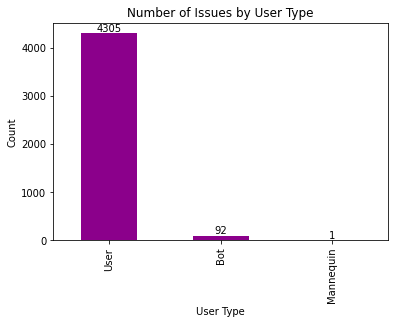

In [0]:
user_counts = data_pd['payload.issue.user.type'].value_counts()

user_counts.plot.bar(color='darkmagenta')
plt.xlabel('User Type')
plt.ylabel('Count')
plt.title('Number of Issues by User Type')

for i, count in enumerate(user_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

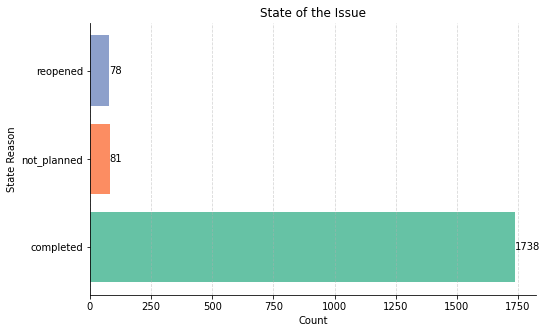

In [0]:
user_counts = data_pd['payload.issue.state_reason'].value_counts()
user_counts = user_counts.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.Set2(range(len(user_counts)))

ax.barh(user_counts.index, user_counts.values, color=colors)

for i, count in enumerate(user_counts.values):
    ax.text(count, i, str(count), ha='left', va='center', fontsize=10)

ax.set_xlabel('Count')
ax.set_ylabel('State Reason')
ax.set_title('State of the Issue')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


Out[123]: <AxesSubplot:title={'center':'Status of the Issue'}, ylabel='Count'>

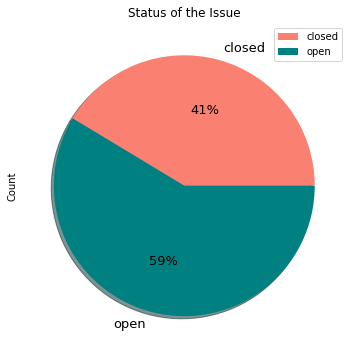

In [0]:
#user_counts = data_pd['payload.issue.state'].value_counts()

stat_counts = data_pd.groupby('payload.issue.state').size().reset_index(name='Count')
stat_counts = age_counts.sort_values(by='Count', ascending=False)

stat_counts.groupby(['payload.issue.state']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%',colors = ['Salmon','Teal'],shadow = True,figsize=(6,6),textprops={'fontsize': 13},title='Status of the Issue')

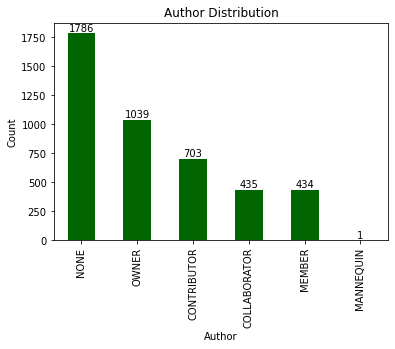

In [0]:
user_counts = data_pd['payload.issue.author_association'].value_counts()
user_counts.plot.bar(color='dark')
plt.xlabel('Author')
plt.ylabel('Count')
plt.title('Author Distribution')

for i, count in enumerate(user_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()